# Visualization

Various aspects of the contraction process can be visualized using the following functions.

In [1]:
%config InlineBackend.figure_formats = ['svg']
import cotengra as ctg

## Hypergraph visualization

The first visualization we can do is to visualize the hypergraph corresponding to the geometry of the tensor network or equation with [`HyperGraph.plot`](cotengra.plot.plot_hypergraph). Hyper edges are shown as a zero size vertex connecting the tensors they appear  on, like a COPY-tensor:

abce,bdf,bdef,a,b,ab->ca


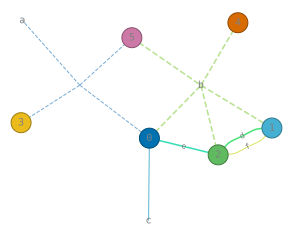

In [2]:
inputs, output, shapes, size_dict = ctg.utils.rand_equation(
    6,
    2,
    n_out=1,
    n_hyper_in=1,
    n_hyper_out=1,
    seed=4,
)
print(ctg.utils.inputs_output_to_eq(inputs, output))
ctg.get_hypergraph(inputs, output, size_dict).plot();

This simple contraction has five types of index:

1. standard inner index - 'e' - which appear on exactly two tensors
2. standard inner multi-indices - 'd', 'f' - which both appear on the same two tensors
3. standard outer index - 'c' - which appears on exactly one tensor and the output
4. hyper inner index - 'b' - which appears on more than two tensors
5. hyper outer index - 'a' - which appears on multiple tensors and the output

The nodes and indices are assigned unique colors by default, with hyper indices
shown as dashed lines.

### Small tree visualization

If the network is small enough and we have a [`ContractionTree`](cotengra.core.ContractionTree) for it, we can also visualize its entirety including all indices involved at each intermediate contraction using the [`ContractionTree.plot_flat`](cotengra.plot.plot_tree_flat) method:

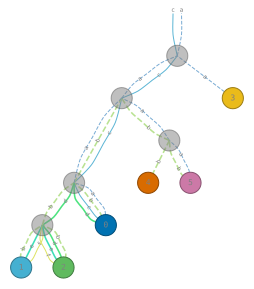

In [3]:
tree = ctg.array_contract_tree(inputs, output, size_dict)
tree.plot_flat();

Here the unique node and index coloring by default matches that of the default hypergraph visualization.
The contraction flows from bottom to top.

For the remaining examples, we'll generate a larger 2D lattice contraction, with no outputs or hyper indices:

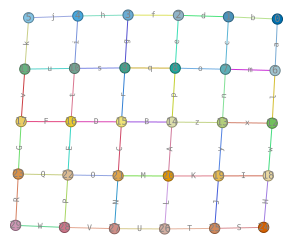

In [4]:
# generate an equation representing a 2D lattice
inputs, output, shapes, size_dict = ctg.utils.lattice_equation([5, 6])
hg = ctg.get_hypergraph(inputs, output, size_dict)
hg.plot(draw_edge_labels=True);

You can turn off the node/edge coloring or set the node coloring to a simple centrality measure like so:

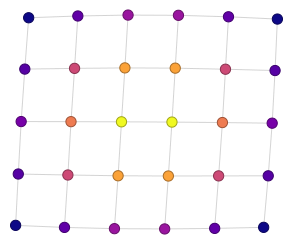

In [5]:
hg.plot(node_color="centrality", edge_color=False);

## Optimizer trials visualization

If we run an hyper optimizer, we can visualize how the scores progress with trials using the
[`HyperOptimizer.plot_trials`](cotengra.plot.plot_trials) method:

In [6]:
opt = ctg.HyperOptimizer(methods=["greedy", "kahypar", "labels"], progbar=True)

# run it and generate a tree
tree = opt.search(inputs, output, size_dict)

  0%|          | 0/128 [00:00<?, ?it/s]

F=3.56 C=4.82 S=6.00 P=8.51: 100%|██████████| 128/128 [00:03<00:00, 33.01it/s]


By default the y-axis is the objective score, but you can specify e.g. `'flops'`':

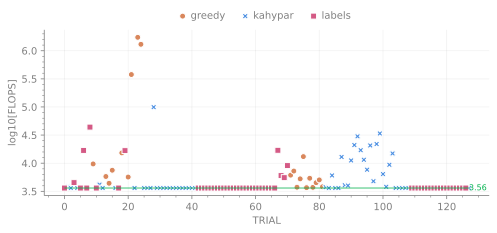

In [7]:
opt.plot_trials(y="flops");

Similarly, you can supply `x="time"` to plot the scores as a function of cumulative CPU time.

We can also plot the distribution of contraction costs against contraction widths using
the [`HyperOptimizer.plot_scatter`](cotengra.plot.plot_scatter) method:

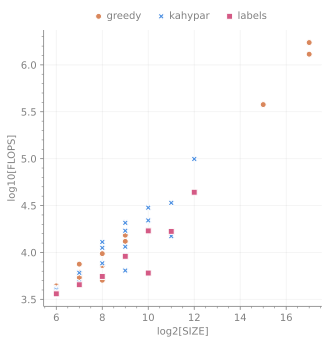

In [8]:
opt.plot_scatter(x="size", y="flops");

You can examine the actual distribution of parameters chosen for each method with `HyperOptimizer.plot_parameters_parallel`:

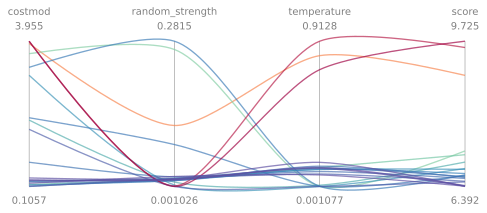

In [11]:
opt.plot_parameters_parallel("greedy");

## Large Tree visualizations

The following visualization functions are available for inspecting a single,
complete [`ContractionTree`](cotengra.core.ContractionTree) once generated.
They mostly wrap [`plot_tree`](cotengra.plot.plot_tree), where you can see
most of the extra options.

### Contractions

[`tree.plot_contractions`](cotengra.plot.plot_contractions)
gives you an overview of the memory and costs throughout the contraction:

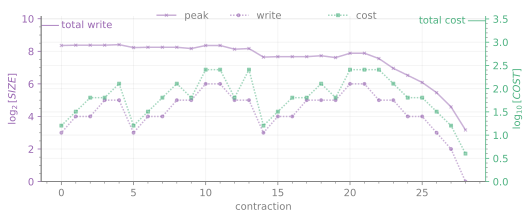

In [9]:
tree.plot_contractions();

Here, `peak` is the memory required for all intermediates to be stored at once,
`write` is the size of the new intermedite tensor, the max of which is the
*contraction width*. `cost` is the scalar operations of each contraction.

The list of corresponding pairwise contractions can be explicitly shown with the [`print_contractions`](cotengra.core.ContractionTree.print_contractions) method:

In [10]:
tree.print_contractions()

(0) cost: 1.6e+01 widths: 3.0,2.0->3.0 type: tensordot
inputs: ih[j],k[j]->
output: ih(k)

(1) cost: 3.2e+01 widths: 3.0,3.0->4.0 type: tensordot
inputs: ih[k],[k]vu->
output: ih(vu)

(2) cost: 6.4e+01 widths: 4.0,4.0->4.0 type: tensordot
inputs: [i]hv[u],[i]ts[u]->
output: hv(ts)

(3) cost: 6.4e+01 widths: 4.0,3.0->5.0 type: tensordot
inputs: h[v]ts,[v]GF->
output: hts(GF)

(4) cost: 1.3e+02 widths: 5.0,4.0->5.0 type: tensordot
inputs: h[t]sG[F],[t]ED[F]->
output: hsG(ED)

(5) cost: 1.6e+01 widths: 3.0,2.0->3.0 type: tensordot
inputs: PV[W],R[W]->
output: PV(R)

(6) cost: 3.2e+01 widths: 3.0,3.0->4.0 type: tensordot
inputs: PV[R],G[R]Q->
output: PV(GQ)

(7) cost: 6.4e+01 widths: 4.0,4.0->4.0 type: tensordot
inputs: [P]VG[Q],E[P]O[Q]->
output: VG(EO)

(8) cost: 1.3e+02 widths: 5.0,4.0->5.0 type: tensordot
inputs: hs[GE]D,V[GE]O->
output: hsD(VO)

(9) cost: 6.4e+01 widths: 4.0,3.0->5.0 type: tensordot
inputs: C[N]MO,[N]UV->
output: CMO(UV)

(10) cost: 2.6e+02 widths: 5.0,5.0->6.0 type: 

The indices are colored according to:

1. blue - appears on left input and is kept
2. green - appears on right input and is kept
3. red - appears on both inputs and is contracted away
4. purple - appears on both inputs and is kept (a 'batch' or hyper index)

### Tent

The most general purpose visualization for the structure of a
[`ContractionTree`](cotengra.core.ContractionTree) is
the [`ContractionTree.plot_tent`](cotengra.plot.plot_tent) method.
This plots the input network (in grey) at the bottom, and the contraction tree
intermediates laid out above. The width and color of the tree edges denote the
intermediate tensor widths, and the size and color of the tree nodes denote the
FLOPs required to contract each intermediate tensor:

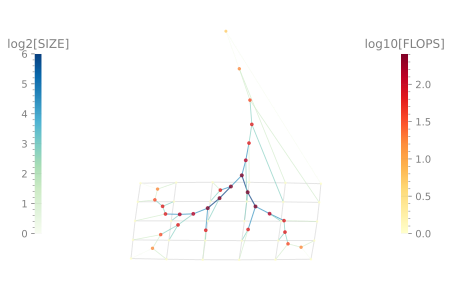

In [11]:
tree.plot_tent();

If you supply `order=True` then the intermediate nodes will be in the exact vertical order than they would be performed:

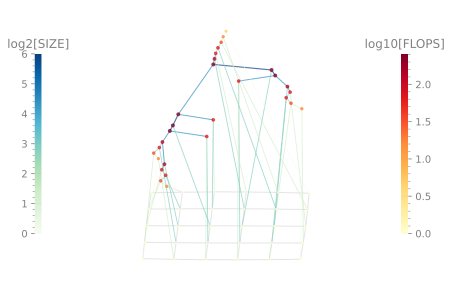

In [12]:
tree.plot_tent(order=True);

```{note}
If you have sliced indices, these will appear as dashed lines in the input graph.
```

### Circuit

If you want to plot only the tree with an emphasis on the order of operations
then you can use the [`ContractionTree.plot_circuit`](cotengra.plot.plot_tree_circuit)
method:

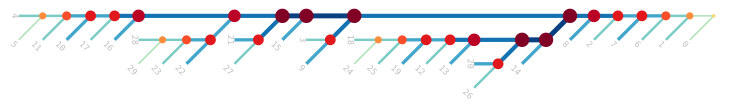

In [13]:
tree.plot_circuit();

### Ring

Another option is the [`ContractionTree.plot_ring`](cotengra.plot.plot_ring)
method which lays out the input network on a ring, with the contraction
tree intermediates laid out towards the center. The more arcs cross between
branches the more expensive that contraction. This can be useful for
inspecting how many 'spines' a contraction has or how *balanced* it is:

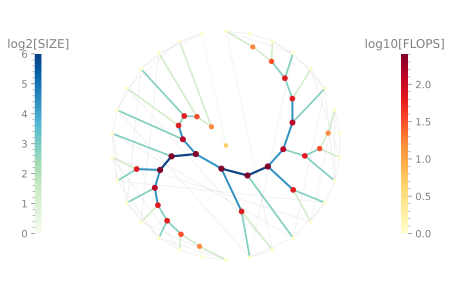

In [14]:
tree.plot_ring();

### Rubberband

For small and close to planar graphs, an alternative visualization is the
[`ContractionTree.plot_rubberband`](cotengra.plot.plot_rubberband) method.
method using [`quimb`](https://github.com/jcmgray/quimb). Here, nodes of the input graph are hierarchically grouped into bands
according to the contraction tree. The order of contraction is represented by
the colors:

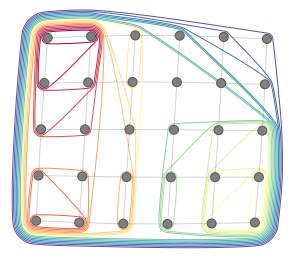

In [15]:
tree.plot_rubberband();

All of the above methods can be pretty extensively customized, including by
supplying custom colormaps. They also return `(fig, ax)` for further
customization or embedding in other plots.

In [16]:
inputs, output, shapes, size_dict = ctg.utils.lattice_equation([5, 5, 5])
opt = ctg.HyperOptimizer(progbar=True, reconf_opts={}, minimize="combo-256")
tree = opt.search(inputs, output, size_dict)

log10[FLOPS]=11.54 log10[COMBO]=11.99 log2[SIZE]=31 log2[PEAK]=32: 100%|█| 128/128 [00:


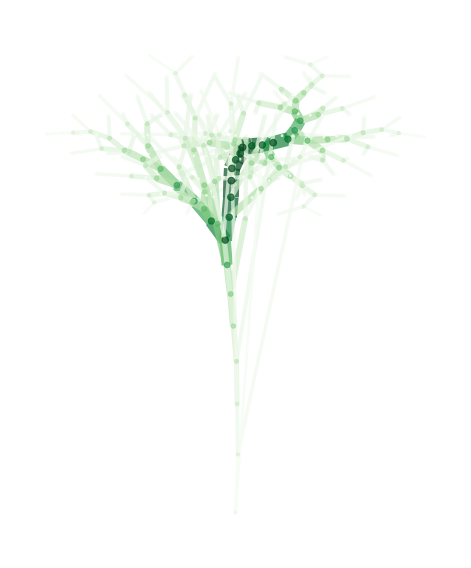

In [17]:
fig, ax = tree.plot_tent(
    raw_edge_alpha=0.0,
    edge_colormap="Greens",
    node_colormap="Greens",
    edge_scale=2,
    node_scale=0.5,
    colorbars=False,
    tree_root_height=-1.0,
    figsize=(10, 10),
)